# Final Project: **Regression Analysis of German Air Fares**
by **Andre Datchev**, **Hannah Kiel**, **Hannes Pohnke**, **Nikolas Jochens**

## **1) Opening Remarks**

We don't know exactly what kind of price configurations were chosen while scraping the dataset. We are assuming that each entry is the cheapest possible configuration for the corresponding flight. So no additional baggage, no extra leg room, no business class and no other extras that would influence the price.

## **2) Setup and Dataset Cleanup**

### **2.1) Imports**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
import random

### **2.2) Dataset**
We will now import our dataset. It can be found under:  [*https://www.kaggle.com/datasets/darjand/domestic-german-air-fares*](https://www.kaggle.com/datasets/darjand/domestic-german-air-fares)<br>
We renamed the csv file to *german_air_fares.csv*.

In [19]:
data = pd.read_csv("german_air_fares.csv", sep=";")
data.head()

departure_city           arrival_city scrape_date departure_date  \
0  TXL Berlin-Tegel       DUS Düsseldorf         18.10.2019     18.11.2019   
1  TXL Berlin-Tegel       DUS Düsseldorf         18.10.2019     18.11.2019   
2  TXL Berlin-Tegel       DUS Düsseldorf         18.10.2019     18.11.2019   
3  TXL Berlin-Tegel       DUS Düsseldorf         18.10.2019     18.11.2019   
4  TXL Berlin-Tegel       DUS Düsseldorf         18.10.2019     18.11.2019   

  departure_date_distance departure_time arrival_time    airline   stops  \
0                 1 month         2:40pm       3:50pm  Eurowings  direct   
1                 1 month         1:00pm       2:15pm  Eurowings  direct   
2                 1 month         8:45pm      10:00pm  Eurowings  direct   
3                 1 month         1:05pm       2:20pm    easyJet  direct   
4                 1 month         5:30pm       6:45pm    easyJet  direct   

  price (€)  
0     33.00  
1     33.00  
2     33.00  
3     37.00  
4     37.00

### **2.3) Dataset Cleanup**

Problem: "1 Stopp" and "1 stop" is the same, but in two different languages. We have the same problem with "Mehrere Fluglinien" and "Multiple Airlines".

In [20]:
# set initial data types
data = data.astype('string')

# rename price column
data = data.rename(columns={'price (€)': 'price'})

# fix price column format errors
data.price = data.price.str.replace(',', '')
data.price = data.price.str.replace('.00', '')

# rename entries in airlines column
data.airline = data.airline.str.replace('Mehrere Fluglinien', 'Multiple Airlines')

# rename entries in stops column
data.stops = data.stops.str.replace('direct', '0')
data.stops = data.stops.str.replace('(1 Stopp)', '1')
data.stops = data.stops.str.replace('(1 stop)', '1')
data.stops = data.stops.str.replace('(2 Stopps)', '2')

# rename entries in departure_date_distance
data.departure_date_distance = data.departure_date_distance.str.replace('2 weeks', '2 week')
data.departure_date_distance = data.departure_date_distance.str.replace('2 week', '2 weeks')
data.departure_date_distance = data.departure_date_distance.str.replace('3 months', '3 month')
data.departure_date_distance = data.departure_date_distance.str.replace('3 month', '3 months')

# rename entries in departure_time column
data.departure_time = data.departure_time.str.replace(' Uhr', '')

# update data types
data = data.astype({'price': 'int32'})

# delete erroneous row
data = data.drop(data[data.price == data.price.max()].index)

data = data.astype({'stops': 'int32'})
data = data.astype({'scrape_date': 'datetime64[ns]'})
data = data.astype({'departure_date': 'datetime64[ns]'})
data = data.astype({'departure_time': 'datetime64[ns]'})



/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3282044467.py:36: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = data.astype({'scrape_date': 'datetime64[ns]'})
/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3282044467.py:37: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = data.astype({'departure_date': 'datetime64[ns]'})
/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3282044467.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = data.astype({'departure_time': 'datetime64[ns]'})


In [21]:
data.dtypes

departure_city             string[python]
arrival_city               string[python]
scrape_date                datetime64[ns]
departure_date             datetime64[ns]
departure_date_distance    string[python]
departure_time             datetime64[ns]
arrival_time               string[python]
airline                    string[python]
stops                               int32
price                               int32
dtype: object

In [22]:
data.head()

departure_city           arrival_city scrape_date departure_date  \
0  TXL Berlin-Tegel       DUS Düsseldorf         2019-10-18     2019-11-18   
1  TXL Berlin-Tegel       DUS Düsseldorf         2019-10-18     2019-11-18   
2  TXL Berlin-Tegel       DUS Düsseldorf         2019-10-18     2019-11-18   
3  TXL Berlin-Tegel       DUS Düsseldorf         2019-10-18     2019-11-18   
4  TXL Berlin-Tegel       DUS Düsseldorf         2019-10-18     2019-11-18   

  departure_date_distance      departure_time arrival_time    airline  stops  \
0                 1 month 2023-12-08 14:40:00       3:50pm  Eurowings      0   
1                 1 month 2023-12-08 13:00:00       2:15pm  Eurowings      0   
2                 1 month 2023-12-08 20:45:00      10:00pm  Eurowings      0   
3                 1 month 2023-12-08 13:05:00       2:20pm    easyJet      0   
4                 1 month 2023-12-08 17:30:00       6:45pm    easyJet      0   

   price  
0     33  
1     33  
2     33  
3     37  
4     37

## **3) Analysis of Dataset**

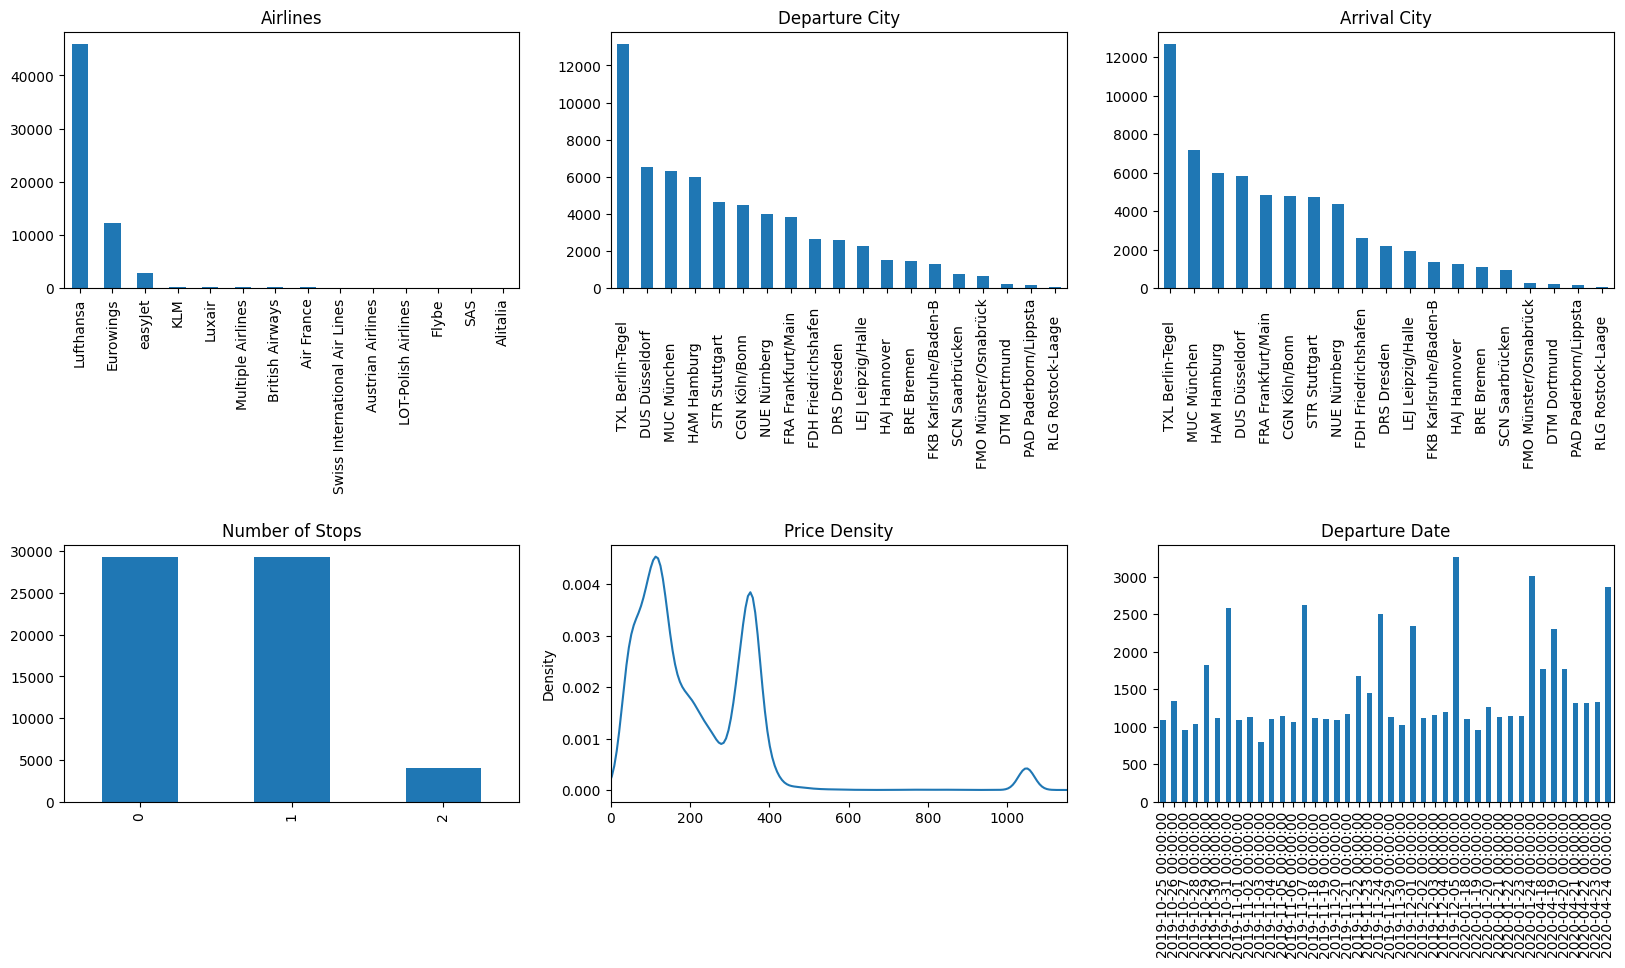

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

data.airline.value_counts().plot(ax=axes[0,0], kind="bar", xlabel="")
_ = axes[0,0].set_title('Airlines')

data.departure_city.value_counts().plot(ax=axes[0,1], kind="bar", xlabel="")
_ = axes[0,1].set_title('Departure City')

data.arrival_city.value_counts().plot(ax=axes[0,2], kind="bar", xlabel="")
_ = axes[0,2].set_title('Arrival City')

data.stops.value_counts().plot(ax=axes[1,0], kind="bar", xlabel="")
_ = axes[1,0].set_title('Number of Stops')

data.price.plot(ax=axes[1,1], kind="kde", xlabel="", xlim=(0,1150))
_ = axes[1,1].set_title('Price Density')

data.departure_date.value_counts().sort_index().plot(ax=axes[1,2], kind="bar", xlabel="")
_ = axes[1,2].set_title('Departure Date')

plt.subplots_adjust(hspace=1)

### **3.3) Median & Mean Price by Weekday, Month and Departure Date Distance**

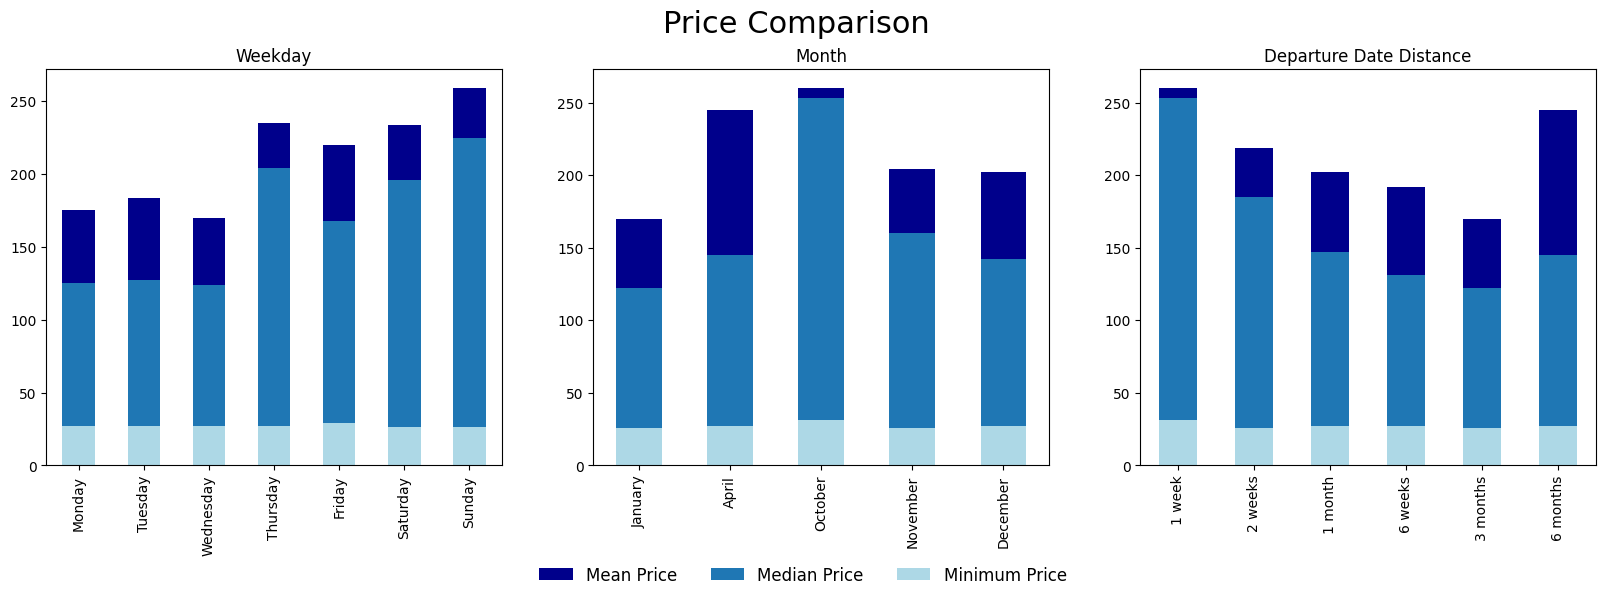

In [24]:
def print_price_distributions(dataset):

    # group by weekday & month & departure date distance
    grouped_weekday = dataset.groupby(dataset.departure_date.dt.day_name())
    grouped_month = dataset.groupby(dataset.departure_date.dt.month_name())
    grouped_departure_distance = dataset.groupby(dataset.departure_date_distance)

    # calculate mean and median prices
    weekday_mean_price = grouped_weekday.price.mean().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
    weekday_median_price = grouped_weekday.price.median().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])
    weekday_min_price = grouped_weekday.price.min().reindex(["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday", "Sunday"])

    month_mean_price = grouped_month.price.mean().reindex(["January","April","October","November","December"])
    month_median_price = grouped_month.price.median().reindex(["January","April","October","November","December"])
    month_min_price = grouped_month.price.min().reindex(["January","April","October","November","December"])

    departure_distance_mean_price = grouped_departure_distance.price.mean().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
    departure_distance_median_price = grouped_departure_distance.price.median().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])
    departure_distance_min_price = grouped_departure_distance.price.min().reindex(["1 week","2 weeks","1 month","6 weeks","3 months", "6 months"])

    # plot mean and median prices
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
    plt.subplots_adjust(bottom=0.22)

    _ = weekday_mean_price.plot(ax=axes[0], xlabel="", kind="bar", color="darkblue")
    _ = weekday_median_price.plot(ax=axes[0], xlabel="", kind="bar")
    _ = weekday_min_price.plot(ax=axes[0], xlabel="", kind="bar", color="lightblue")
    _ = axes[0].set_title('Weekday')

    _ = month_mean_price.plot(ax=axes[1], xlabel="", kind="bar", color="darkblue")
    _ = month_median_price.plot(ax=axes[1], xlabel="", kind="bar")
    _ = month_min_price.plot(ax=axes[1], xlabel="", kind="bar", color="lightblue")
    _ = axes[1].set_title('Month')

    _ = departure_distance_mean_price.plot(ax=axes[2], xlabel="", kind="bar", color="darkblue")
    _ = departure_distance_median_price.plot(ax=axes[2], xlabel="", kind="bar")
    _ = departure_distance_min_price.plot(ax=axes[2], xlabel="", kind="bar", color="lightblue")
    _ = axes[2].set_title('Departure Date Distance')

    _ = fig.suptitle('Price Comparison', fontsize=22)
    _ = fig.legend(labels=["Mean Price", "Median Price", "Minimum Price"], loc="lower center", ncol=3, frameon=False, fontsize=12)

print_price_distributions(data)

### **3.4) Mean price per airport**

### **3.5) Median & Mean Price per Stop**

## **4) Train & Test Subsets**

### **4.1) Convert non number values into sensible numbers**

### **4.2) Add mean, median, min and max as new columns**

In [25]:
# prepare for subset creation
new_data = data.drop(['scrape_date', 'arrival_time', 'departure_time', 'airline', 'stops'], axis=1)

# group by date
grouped_date = data.groupby(data.departure_date)

# calculate mean, median, maximum and minimum price for each day
day_mean_price = grouped_date.price.mean().rename('mean_price')
day_median_price = grouped_date.price.median().rename('median_price')
day_min_price = grouped_date.price.min().rename('min_price')
day_max_price = grouped_date.price.max().rename('max_price')

# add mean, median, maximum and minimum price columns to data
new_data = new_data.merge(day_mean_price, on='departure_date')
new_data = new_data.merge(day_median_price, on='departure_date')
new_data = new_data.merge(day_min_price, on='departure_date')
new_data = new_data.merge(day_max_price, on='departure_date')

### **4.3) Perform train/test split while keeping single days together**

In [26]:
# sort by departure date
new_data = new_data.sort_values(by='departure_date')

# Perform split while keeping days together
train, test = train_test_split(new_data, test_size=0.2, stratify=new_data['departure_date'])

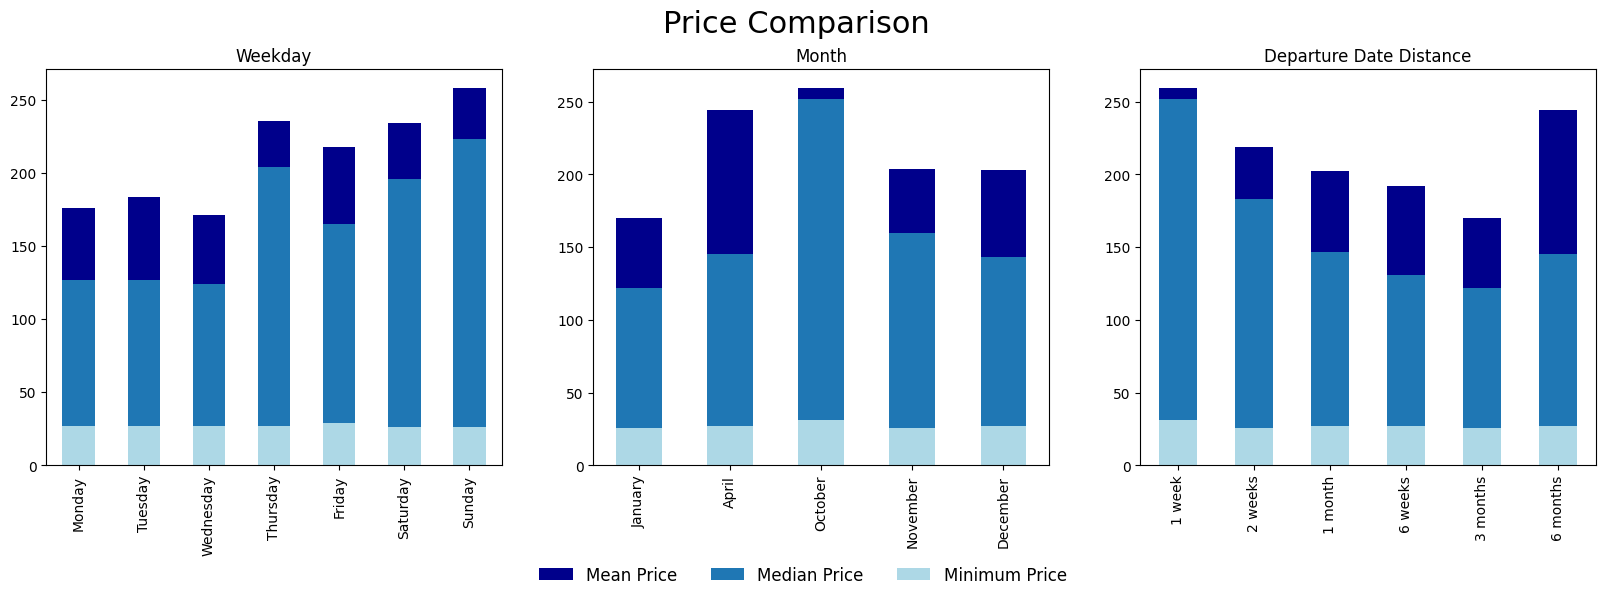

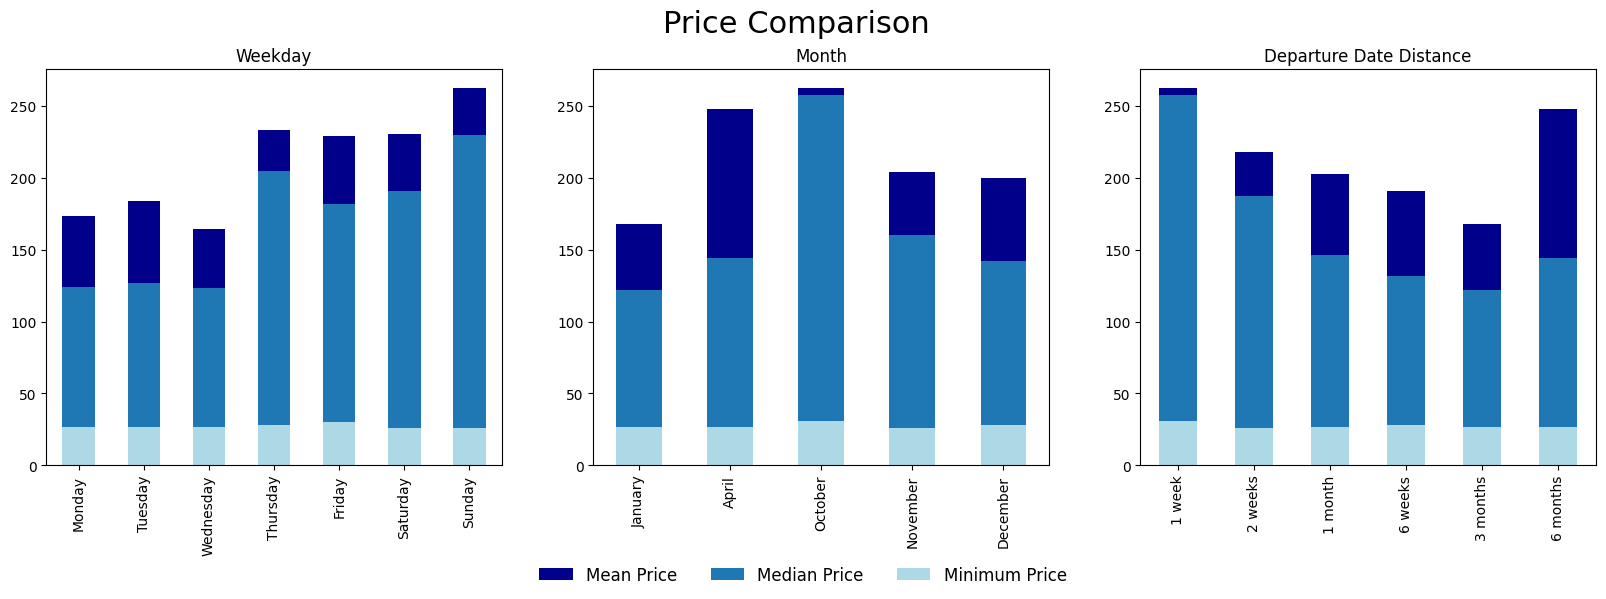

In [27]:
print_price_distributions(train)
print_price_distributions(test)

In [28]:
# reorder columns
departure_date_column = new_data.pop('departure_date') 
new_data.insert(0, 'departure_date', departure_date_column)
new_data.sort_index(inplace=True)
new_data.sort_index(axis=1)

# get unique values
unique_days = new_data.departure_date.unique()

# randomly get 10 of the 40 days contained in new_data
test_split_temp = pd.DataFrame(unique_days, columns=["departure_date"]).sample(n=10, random_state=200)

test_split = pd.merge(test_split_temp, new_data, how ='inner', on =['departure_date', 'departure_date'])
test_split.sort_index(inplace=True)
test_split.sort_index(axis=1)


train_split = pd.DataFrame(index=new_data.index, columns=new_data.columns)

# Iterate through columns and rows to find differences
for row in new_data.columns:
    train_split[row] = ~new_data[row].equals(test_split[row])

print(len(new_data))
print(len(test_split))
print(len(train_split))

# divide by months
# divide by weekdays
# divide by departure_date_distance

#new_data.head()

62626
14374
62626


## **5) Training of Regression Models**

In [29]:
X = train.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = train.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
print(X)
print(Y)
#linear_regressor = LinearRegression()  # create object for the class
#linear_regressor.fit(X, Y)  # perform linear regression
#Y_pred = linear_regressor.predict(X)  # make predictions

<StringArray>
[
['FKB Karlsruhe/Baden-B'],
['NUE Nürnberg         '],
['TXL Berlin-Tegel     '],
['FRA Frankfurt/Main   '],
['FMO Münster/Osnabrück'],
['TXL Berlin-Tegel     '],
['CGN Köln/Bonn        '],
['FRA Frankfurt/Main   '],
['DUS Düsseldorf       '],
['TXL Berlin-Tegel     '],
['DUS Düsseldorf       '],
['TXL Berlin-Tegel     '],
['HAM Hamburg          '],
['NUE Nürnberg         '],
['MUC München          '],
['DUS Düsseldorf       '],
['TXL Berlin-Tegel     '],
['STR Stuttgart        '],
['STR Stuttgart        '],
['STR Stuttgart        '],
['TXL Berlin-Tegel     '],
['TXL Berlin-Tegel     '],
['TXL Berlin-Tegel     '],
['MUC München          '],
['MUC München          '],
['MUC München          '],
['FRA Frankfurt/Main   '],
['HAM Hamburg          '],
['TXL Berlin-Tegel     '],
['NUE Nürnberg         '],
['FRA Frankfurt/Main   '],
['HAJ Hannover         '],
['DRS Dresden          '],
['TXL Berlin-Tegel     '],
['STR Stuttgart        '],
['PAD Paderborn/Lippsta'],
['MUC Münche

### **5.1) Linear Regression**

### **5.2) Polynomial Regression**

## **6) Training of Neural Network**

In [30]:
#pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from sklearn.compose import ColumnTransformer

# Load the dataset
data = pd.read_csv("german_air_fares.csv", sep=";")

# Apply the preprocessing steps as you described
data = data.astype('string')
data = data.rename(columns={'price (€)': 'price'})
data.price = data.price.str.replace(',', '').str.replace('.00', '')
data.airline = data.airline.str.replace('Mehrere Fluglinien', 'Multiple Airlines')
data.stops = data.stops.str.replace('direct', '0').str.replace('(1 Stopp)', '1').str.replace('(1 stop)', '1').str.replace('(2 Stopps)', '2')
data.departure_date_distance = data.departure_date_distance.str.replace('2 weeks', '2 week').str.replace('2 week', '2 weeks').str.replace('3 months', '3 month').str.replace('3 month', '3 months')
data.departure_time = data.departure_time.str.replace(' Uhr', '')
data = data.astype({'price': 'int32'})
data = data.drop(data[data.price == data.price.max()].index)
data = data.astype({'stops': 'int32'})
data = data.astype({'scrape_date': 'datetime64[ns]', 'departure_date': 'datetime64[ns]', 'departure_time': 'datetime64[ns]'})

# Select features and label
features = data[['airline', 'stops', 'departure_date', 'departure_time', 'departure_date_distance']]
label = data['price']

# One-hot encode categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['stops']),
        ('cat', OneHotEncoder(), ['airline', 'departure_date_distance'])
    ])

X = preprocessor.fit_transform(features)
y = label.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3906074898.py:22: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = data.astype({'scrape_date': 'datetime64[ns]', 'departure_date': 'datetime64[ns]', 'departure_time': 'datetime64[ns]'})
/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3906074898.py:22: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = data.astype({'scrape_date': 'datetime64[ns]', 'departure_date': 'datetime64[ns]', 'departure_time': 'datetime64[ns]'})
/var/folders/f3/35whff8j4zvbd55tm9pdq16r0000gn/T/ipykernel_36205/3906074898.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify

In [32]:

# Create a neural network model
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")


Epoch 1/10
1566/1566 [==============================] - 1s 654us/step - loss: 25597.2109
Epoch 2/10
1566/1566 [==============================] - 1s 713us/step - loss: 19958.8145
Epoch 3/10
1566/1566 [==============================] - 1s 649us/step - loss: 19541.4258
Epoch 4/10
1566/1566 [==============================] - 1s 603us/step - loss: 19255.0859
Epoch 5/10
1566/1566 [==============================] - 1s 631us/step - loss: 18995.5879
Epoch 6/10
1566/1566 [==============================] - 1s 634us/step - loss: 18805.7285
Epoch 7/10
1566/1566 [==============================] - 1s 633us/step - loss: 18650.1016
Epoch 8/10
1566/1566 [==============================] - 1s 623us/step - loss: 18563.5781
Epoch 9/10
1566/1566 [==============================] - 1s 614us/step - loss: 18511.3555
Epoch 10/10
392/392 [==============================] - 0s 487us/step - loss: 19290.0020
Test loss: 19290.001953125


392/392 [==============================] - 0s 452us/step
Vorhergesagter Preis: 312.85540771484375, Tatsächlicher Preis: 365
Vorhergesagter Preis: 312.85540771484375, Tatsächlicher Preis: 325
Vorhergesagter Preis: 157.20526123046875, Tatsächlicher Preis: 190
Vorhergesagter Preis: 271.1504821777344, Tatsächlicher Preis: 298
Vorhergesagter Preis: 282.9315490722656, Tatsächlicher Preis: 1058
Vorhergesagter Preis: 132.80313110351562, Tatsächlicher Preis: 149
Vorhergesagter Preis: 157.20526123046875, Tatsächlicher Preis: 159
Vorhergesagter Preis: 157.20526123046875, Tatsächlicher Preis: 204
Vorhergesagter Preis: 312.85540771484375, Tatsächlicher Preis: 351
Vorhergesagter Preis: 258.58612060546875, Tatsächlicher Preis: 118
Vorhergesagter Preis: 271.1504821777344, Tatsächlicher Preis: 363
Vorhergesagter Preis: 129.584228515625, Tatsächlicher Preis: 143
Vorhergesagter Preis: 257.93072509765625, Tatsächlicher Preis: 322
Vorhergesagter Preis: 257.93072509765625, Tatsächlicher Preis: 120
Vorherges

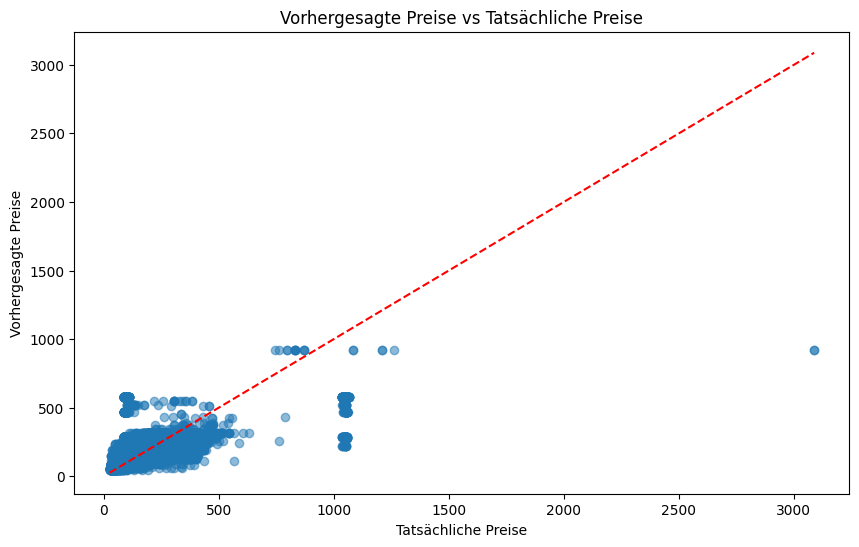

In [33]:
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score


predictions = model.predict(X_test)

for i in range(100):  # Anzeigen der ersten 10 Vorhersagen
    print(f"Vorhergesagter Preis: {predictions[i][0]}, Tatsächlicher Preis: {y_test[i]}")

# Ihr vorheriger Code, um das Modell zu trainieren und Vorhersagen zu machen...

# Berechnen der Metriken
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Ausgabe der Metriken
print(f"Mittlerer absoluter Fehler (MAE): {mae:.2f}")
print(f"R²-Wert: {r2:.2f}")

# Visualisierung der Vorhersagen im Vergleich zu den tatsächlichen Werten
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.title('Vorhergesagte Preise vs Tatsächliche Preise')
max_price = max(y_test.max(), predictions.max())
min_price = min(y_test.min(), predictions.min())
plt.plot([min_price, max_price], [min_price, max_price], 'r--')  # Rote gestrichelte Linie

plt.show()

## **7) Comparison of Models**

## **8) Final Thoughts**